In [1]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import *
from scipy import optimize, integrate
from matplotlib import cm
import torch
import torch.autograd as autograd
torch.set_default_dtype(torch.float64)
import copy
import datetime
import tikzplotlib

from torch.distributions import uniform
# from PyTorch_LBFGS.functions.LBFGS import LBFGS, FullBatchLBFGS
from DBSProblem import DBSProblem

import scipy.io as sio

### Action potential and gating variables of normal HH model

In [3]:
# load normal sol generated in matlab
z_true = torch.from_numpy(np.load("../target_solution/target_sol.npz")["target_sol"])
n_steps = z_true.shape[0]
z_true.shape

torch.Size([3000, 4])

In [4]:
# includes the Hodgkin-Huxley neuron model and OC setup
normal_params = [1.0, 120.0, 36.0, 0.3, 115.0, -12.0, 10.613]   # pathological params set as default
prob = DBSProblem(z_true) # uses pathological
t = prob.t
T = prob.T
s = np.linspace(t, T, n_steps)

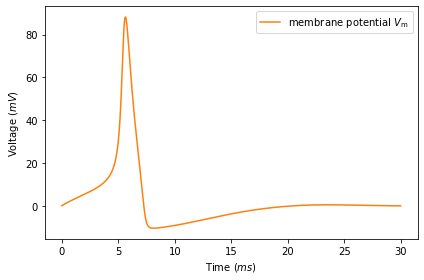

In [5]:
plt.plot(s, z_true[:,0], 'C1', label=r'membrane potential $V_{\rm m}$')
plt.xlabel(r'Time ($ms$)')
plt.ylabel(r'Voltage ($mV$)')
plt.legend()
plt.savefig('../experiments/images/normal_HH_action_potential.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/normal_HH_action_potential.tex')

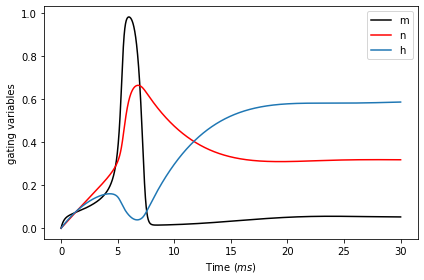

In [6]:
plt.plot(s, z_true[:,1], 'k', label='m')
plt.plot(s, z_true[:,2], 'r', label='n')
plt.plot(s, z_true[:,3], '#1f77b4', label='h')
plt.xlabel(r'Time ($ms$)')
plt.ylabel('gating variables')
plt.legend()
plt.savefig('../experiments/images/normal_HH_gating_variables.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/normal_HH_gating_variables.tex')

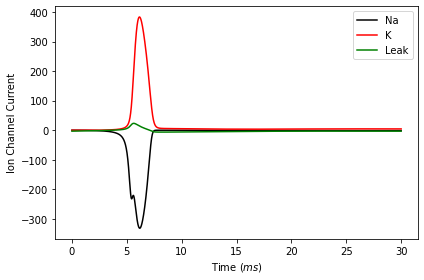

In [7]:

# ionic conductance for sodium, potassium, and leakage channels [mS/cm^2]
gNa = 120
gK = 36.0
gL = 0.3

# reversal potential (mV)
ENa = 115.0
EK = -12.0
EL = 10.613

voltage = []
mgate = []
ngate = []
hgate=[]
Na_current = []
K_current = []
L_current = []

for i in range(n_steps):
    V = z_true[i,0]
    m = z_true[i,1]
    n = z_true[i,2]
    h = z_true[i,3]

    i_Na = gNa * m**3 * h * (V - ENa)
    i_K = gK * n**4 * (V - EK)
    i_L = gL * (V - EL)
    
    voltage.append(V)
    mgate.append(m)
    ngate.append(n)
    hgate.append(h)
    Na_current.append(i_Na)
    K_current.append(i_K)
    L_current.append(i_L)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel('Ion Channel Current')
ax.plot(s, Na_current, 'k', label='Na')
ax.plot(s, K_current, 'r', label='K')
ax.plot(s, L_current, 'g', label='Leak')
plt.legend(loc='best')
plt.savefig('../experiments/images/normal_HH_ion_channels.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/normal_HH_ion_channels.tex')

### Normal vs Pathological Voltage

In [8]:
""" Visualize HH dynamics """ 
I_dbs = torch.zeros(n_steps) # external stimulus applied

dt = 0.01 # 1/n_steps 
state = prob.xInit  # torch.tensor([[-65.0000, 0.0529, 0.3177, 0.5961]], dtype=torch.float64) # 
print("init state: ", state)

Vm_hist = torch.zeros(n_steps)
m_hist = torch.zeros(n_steps)
n_hist = torch.zeros(n_steps)
h_hist = torch.zeros(n_steps)

iNa_hist = torch.zeros(n_steps)
iK_hist = torch.zeros(n_steps)
iL_hist = torch.zeros(n_steps)

for i in range(int(I_dbs.shape[0])):
    Vm_hist[i] = state[:, 0]
    m_hist[i] = state[:, 1]
    n_hist[i] = state[:, 2]
    h_hist[i] = state[:, 3]
    
    iNa_hist[i] = prob.gNa * m_hist[i]**3 * h_hist[i] * (Vm_hist[i] - prob.ENa)
    iK_hist[i] = prob.gK * n_hist[i]**4 * (Vm_hist[i] - prob.EK)
    iL_hist[i] = prob.gL * (Vm_hist[i] - prob.EL)

    state += dt*prob.f(t, state, I_dbs[i])

init state:  tensor([[0., 0., 0., 0.]])


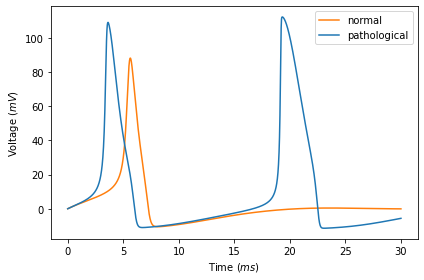

In [9]:
plt.plot(s, z_true[:,0], 'C1', label='normal') # normal
plt.plot(s, Vm_hist, label='pathological') # pathological
plt.xlabel(r'Time ($ms$)')
plt.ylabel(r'Voltage ($mV$)')
# plt.ylabel('membrane potential (mV)')
plt.legend()
# plt.axhline(y=prob.xtarget[0][0].item(), label=r'resting potential', color='k', linestyle='dashed')
# plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3)
plt.savefig('../experiments/images/normal_vs_pathological_voltage.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/normal_vs_pathological_voltage.tex')

#### Local Solution: Pathological

In [10]:
local_sol = sio.loadmat('./local_solution/local_solution_24-Aug-2023_17_12_32.mat')
local_z0 = local_sol['x'][:, 0]
local_z1 = local_sol['x'][:, 1]
local_z2 = local_sol['x'][:, 2]
local_z3 = local_sol['x'][:, 3]
local_u = local_sol['x'][:, 4]
init_trajec = local_sol['ztraj0']
local_INa = local_sol['INa']
local_IK = local_sol['IK']
local_IL = local_sol['IL']

In [11]:
s1 = np.linspace(t, T, n_steps)[::2]
s1

array([0.00000000e+00, 2.00066689e-02, 4.00133378e-02, ...,
       2.99499833e+01, 2.99699900e+01, 2.99899967e+01])

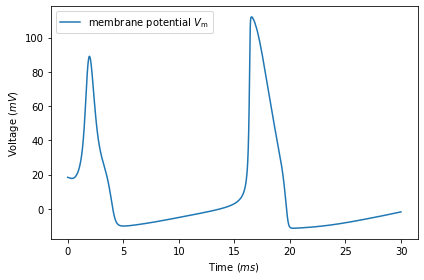

In [12]:
plt.plot(s1, init_trajec[:,0], 'C0', label=r'membrane potential $V_{\rm m}$')
plt.xlabel(r'Time ($ms$)')
plt.ylabel(r'Voltage ($mV$)')
plt.legend()
plt.savefig('../experiments/images/pathological_HH_action_potential.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/pathological_HH_action_potential.tex')

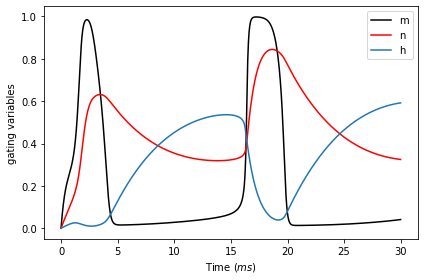

In [13]:
# plot gating variables
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time ($ms$)')
ax.set_ylabel('gating variables')
ax.plot(s1, init_trajec[:,1], 'k', label='m')
ax.plot(s1, init_trajec[:,2], 'r', label='n')
ax.plot(s1, init_trajec[:,3], '#1f77b4', label='h')
plt.legend()
plt.savefig('../experiments/images/pathological_HH_gating_variables.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/pathological_HH_gating_variables.tex')

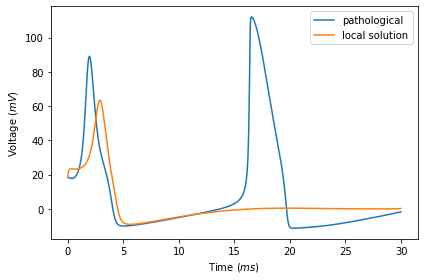

In [14]:
plt.plot(s1, init_trajec[:, 0], label='pathological')
plt.plot(s1, local_z0, 'C1', label='local solution')
plt.xlabel(r'Time ($ms$)')
plt.ylabel(r'Voltage ($mV$)')
# plt.axhline(y=prob.xtarget[0][0].item(), label=r'resting potential', color='k', linestyle='dashed')
plt.legend()
plt.savefig('../experiments/images/local_pathological_action_potential.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/local_pathological_action_potential.tex')

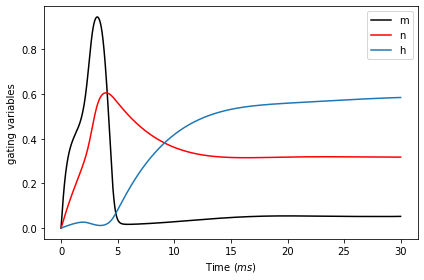

In [15]:
# plot gating variables
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time ($ms$)')
ax.set_ylabel('gating variables')
ax.plot(s1, local_z1, 'k', label='m')
ax.plot(s1, local_z2, 'r', label='n')
ax.plot(s1, local_z3, '#1f77b4', label='h')
plt.legend()
plt.savefig('../experiments/images/local_pathological_gating_variables.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/local_pathological_gating_variables.tex')

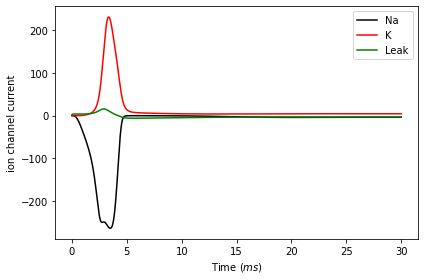

In [16]:
# plot ion channels
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r'Time ($ms$)') # Time ($ms$)
ax.set_ylabel('ion channel current')
ax.plot(s1, local_INa, 'k', label='Na')
ax.plot(s1, local_IK, 'r', label='K')
ax.plot(s1, local_IL, 'g', label='Leak')
plt.legend(loc='best')
plt.savefig(f'../experiments/images/local_pathological_ion_channels.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/local_pathological_ion_channels.tex')

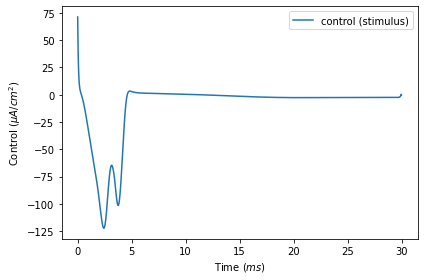

In [17]:
# plot controls
plt.plot(s1, local_u, label='control (stimulus)')
plt.xlabel(r'Time ($ms$)') # Time ($ms$)
plt.ylabel(r'Control ($\mu A/cm^2$)')
plt.legend()
plt.savefig(f'../experiments/images/local_pathological_controls.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/local_pathological_controls.tex')

#### NN Solution: Pathological

In [18]:
exp_id = '_m32_nTh2_lr0-012023_08_28_11_19_36'
nn_controls = np.load(f'./data/controls/{exp_id}_iter_998_controls.npy')
nn_z0 = np.load(f'./data/ion_channels/{exp_id}_iter_998_voltage.npy')
nn_init_z0 = np.load(f'./data/ion_channels/{exp_id}_iter_0_voltage.npy')
nn_z1 = np.load(f'./data/gate_variables/{exp_id}_iter_998_m_gate.npy')
nn_z2 = np.load(f'./data/gate_variables/{exp_id}_iter_998_n_gate.npy')
nn_z3 = np.load(f'./data/gate_variables/{exp_id}_iter_998_h_gate.npy')
nn_INa = np.load(f'./data/ion_channels/{exp_id}_iter_998_Na_current.npy')
nn_IK = np.load(f'./data/ion_channels/{exp_id}_iter_998_K_current.npy')
nn_IL = np.load(f'./data/ion_channels/{exp_id}_iter_998_L_current.npy')

In [19]:
nt = nn_z0.shape[0]
s2 = np.arange(0, nt)*30/nt
s2.shape

(1501,)

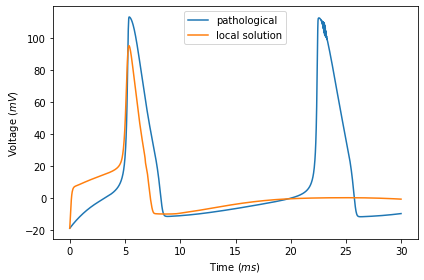

In [20]:
plt.plot(s2, nn_init_z0, label='pathological')
plt.plot(s2, nn_z0, 'C1', label='local solution')
plt.xlabel(r'Time ($ms$)')
plt.ylabel(r'Voltage ($mV$)')
# plt.axhline(y=prob.xtarget[0][0].item(), label=r'resting potential', color='k', linestyle='dashed')
plt.legend()
plt.savefig('../experiments/images/NN_pathological_action_potential.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/NN_pathological_action_potential.tex')

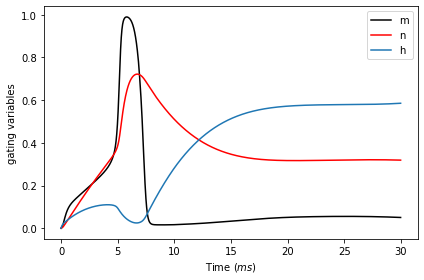

In [21]:
# plot gating variables
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time ($ms$)')
ax.set_ylabel('gating variables')
ax.plot(s2, nn_z1, 'k', label='m')
ax.plot(s2, nn_z2, 'r', label='n')
ax.plot(s2, nn_z3, '#1f77b4', label='h')
plt.legend()
plt.savefig('../experiments/images/NN_pathological_gating_variables.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/NN_pathological_gating_variables.tex')

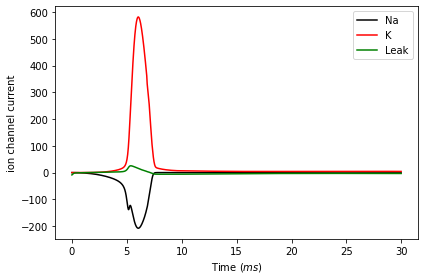

In [22]:
# plot ion channels
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r'Time ($ms$)') # Time ($ms$)
ax.set_ylabel('ion channel current')
ax.plot(s2, nn_INa, 'k', label='Na')
ax.plot(s2, nn_IK, 'r', label='K')
ax.plot(s2, nn_IL, 'g', label='Leak')
plt.legend(loc='best')
plt.savefig(f'../experiments/images/NN_pathological_ion_channels.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/NN_pathological_ion_channels.tex')

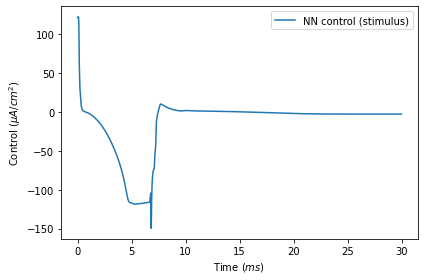

In [23]:
# plot controls
# plt.plot(s, local_u, label='control (stimulus)')
plt.plot(s2, nn_controls, label='NN control (stimulus)')
plt.xlabel(r'Time ($ms$)') # Time ($ms$)
plt.ylabel(r'Control ($\mu A/cm^2$)')
plt.legend()
plt.savefig(f'../experiments/images/NN_pathological_controls.pdf', dpi=1000)
tikzplotlib.save(f'../experiments/images/NN_pathological_controls.tex')